# BTC ML/DL Trading strategy

In [1]:
# Enabling the notebook execution from this sub-folder
import sys, os, ipynbname
NOTEBOOK_NAME = f"{ipynbname.name()}.ipynb"
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(NOTEBOOK_NAME), os.path.pardir)))

In [2]:
# Importin utils global variables and methods
from src.Utils import *

## Preliminary data import & handling

In [15]:
# Importing Bitcoin pre-processed financial data
df = pq.read_pandas(source=f"{Utils.ASSETS_FOLDER}/parquet/{Utils.get_asset_id('Bitcoin')}.parquet").to_pandas()

In [16]:
# Deepcopying the dataset
df_ = df.copy(deep=True)

**Reference**:
1. https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

In [17]:
# Displaying first rows
df.head()

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2018-01-01 00:01:00,229,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093
2018-01-01 00:02:00,235,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591
2018-01-01 00:03:00,528,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014
2018-01-01 00:04:00,435,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101
2018-01-01 00:05:00,742,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842


In [19]:
# Displaying column informations
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2136278 entries, 2018-01-01 00:01:00 to 2022-01-24 00:00:00
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Count   int32  
 1   Open    float64
 2   High    float64
 3   Low     float64
 4   Close   float64
 5   Volume  float64
 6   VWAP    float64
dtypes: float64(6), int32(1)
memory usage: 122.2 MB


In [20]:
# Resampling to 10-min bins
df = df.resample("10T").agg({
    "Count": "median",
    "Open": "first",
    "High": "max",
    "Low": "min",
    "Close": "last",
    "Volume": "mean",
    "VWAP": "mean"
})

# Removing NaN and broadcasting it to `Count`
df["Count"] = pd.to_numeric(arg=df["Count"], downcast="integer")
df.fillna(method="bfill", inplace=True)

In [21]:
# Displaying first rows
df.head()

,Count,Open,High,Low,Close,Volume,VWAP
timestamp,,,,,,,
2018-01-01 00:00:00,437.0,13835.194,14052.3,13501.01,13720.260,60.545301,13756.177556
2018-01-01 00:10:00,301.0,13713.610,13948.6,13400.01,13626.110,49.918511,13665.050348
2018-01-01 00:20:00,308.0,13626.248,13826.8,13410.44,13648.280,53.002165,13623.876888
2018-01-01 00:30:00,228.5,13638.620,13800.0,13461.74,13636.600,36.841839,13652.429477
2018-01-01 00:40:00,245.0,13649.296,13800.0,13450.00,13693.004,48.451182,13640.833680


In [22]:
# Some statistical analysis
df.describe()

,Count,Open,High,Low,Close,Volume,VWAP
count,213697.000000,213697.000000,213697.000000,213697.000000,213697.000000,213697.000000,213697.000000
mean,1036.575761,18706.849538,18780.568915,18636.490972,18706.957485,89.569931,18706.905651
std,1279.367076,17863.740822,17904.317644,17814.076700,17863.726108,114.678865,17863.725743
min,1.000000,3153.860000,3232.600000,3120.000000,3160.405000,0.001104,3159.199122
25%,318.000000,7124.448333,7159.000000,7098.480000,7124.657143,36.544792,7124.256692
50%,614.000000,9504.030000,9530.000000,9476.660000,9503.897143,57.727493,9503.429433
75%,1311.500000,32225.492857,32361.000000,32084.715549,32225.264388,98.577041,32221.782272
max,55717.500000,68716.598333,69024.200000,68447.000000,68724.006667,3985.862343,68619.267512


## Data aggregation

We are encouraged to add:
- additional metrics (RSI, moving averages, ...) and indicators from technical analysis
- additional data sources (from historical data API including FTX or Binance APIs)
- use of resampling routine to:
    - identify patterns
    - reduce the length of our data sample

### Log-returns & Day-time range

In [23]:
# Adding the daytime range for each line
try:
    df_t = [obs.hour for obs in list(df.index)]
    df["TimeRange"] = [Utils.get_daytime_range(time_) for time_ in df_t]
except KeyError:
    pass

In [24]:
# Computing log-returns
df["LogReturns"] = np.log(df["Close"]).diff()
df["LogReturns"].fillna(0, inplace=True)

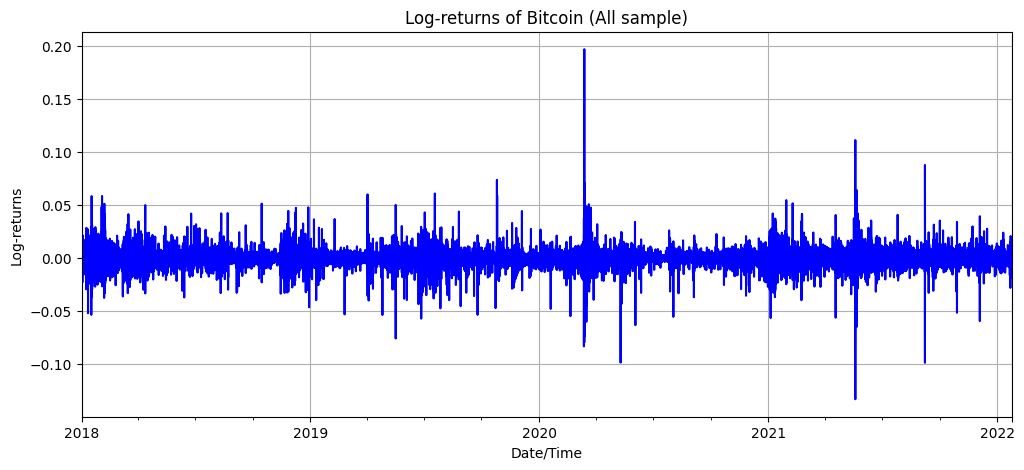

In [25]:
# Plotting log-returns
_ = df["LogReturns"].plot()
_ = plt.title("Log-returns of Bitcoin (All sample)")
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Log-returns")
_ = plt.grid()

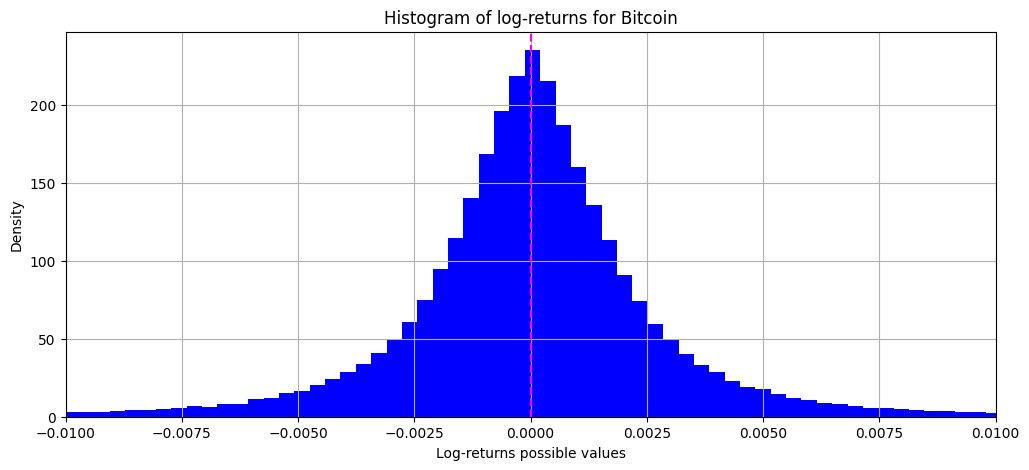

In [26]:
# Plotting log-returns
_ = df["LogReturns"].hist(bins=1000, density=True)
_ = plt.xlim([-0.01, 0.01])
_ = plt.title("Histogram of log-returns for Bitcoin")
_ = plt.xlabel("Log-returns possible values")
_ = plt.axvline(x = 0, color="magenta", ls="--")
_ = plt.ylabel("Density")

### Technical analysis indicators & Moving averages

In [27]:
def rsi(df, periods = 10, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    # Computing the Close price delta
    close_delta = df["Close"].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
        # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
    
    # Computing the RSI
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [40]:
# Computing Rolled average close price
#df["Rolled_Avg_Close"] = df["Close"].rolling(window=10).mean()

# Computing correlation
#df["Corr"] = df["Close"].rolling(window=10).corr(df["Rolled_Avg_Close"])

# Computing Open-Close indicator
#df["Open-Close"] = df["Open"] - df["Close"].shift(1)

# Computing Open-Open indicator
#df["Open-Open"] = df["Open"] - df["Open"].shift(1)

# Computing the RSI () indicator
df["RSI"] = rsi(df)

# Computing the Bollinger Bands (BB) indicators
#upper_2sd, mid_2sd, lower_2sd = ta.BBANDS(df["Close"], 
#                                          nbdevup=2,
#                                          nbdevdn=2,
#                                          timeperiod=20)
#df["BBANDS_U"] = upper_2sd
#df["BBANDS_M"] = mid_2sd
#df["BBANDS_L"] = lower_2sd

# Computing SMA moving averages for various time windows
df["SMA_SLOW"] = ta.SMA(df["Close"], timeperiod=5)
#df["SMA_MEDIUM"] = ta.SMA(df["Close"], timeperiod=10)
#df["SMA_FAST"] = ta.SMA(df["Close"], timeperiod=15)

# TODO: Adding other technical analysis indicator
# Momentum
# Standard deviation
# ...

In [41]:
# Getting DataFrame shape
df_shape_before = df.shape[0]

# Dropping newly-created NaN values
df.dropna(inplace=True)

# Getting DataFrame shape
df_shape_after = df.shape[0]

# Getting number of deletedrows
abs(df_shape_after - df_shape_before)

10

In [42]:
# Displaying DataFrame
df.head()

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,RSI,SMA_SLOW
timestamp,,,,,,,,,,,
2018-01-01 03:20:00,244.5,13545.052,13888.0,13428.03,13627.612,49.965753,13584.533490,5,0.006160,74.071440,13489.6124
2018-01-01 03:30:00,326.0,13633.470,13898.9,13400.00,13563.692,40.981728,13624.720631,5,-0.004702,63.645898,13513.1720
2018-01-01 03:40:00,168.0,13561.794,13798.5,13440.00,13549.480,25.024610,13570.538872,5,-0.001048,61.507199,13540.3736
2018-01-01 03:50:00,272.5,13546.378,13787.2,13360.00,13496.986,39.879553,13502.166655,5,-0.003882,54.052848,13556.3376
2018-01-01 04:00:00,247.0,13495.702,13809.8,13313.00,13462.424,33.365610,13499.491085,5,-0.002564,49.650781,13540.0388


### External data sources (e.g. Binance, Coinbase, FTX, ...)

$\longrightarrow$ Potential extension (10-min data of **S&P 500**, **DJIA**)

## Data pre-processing

In [43]:
df.head()

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,RSI,SMA_SLOW
timestamp,,,,,,,,,,,
2018-01-01 03:20:00,244.5,13545.052,13888.0,13428.03,13627.612,49.965753,13584.533490,5,0.006160,74.071440,13489.6124
2018-01-01 03:30:00,326.0,13633.470,13898.9,13400.00,13563.692,40.981728,13624.720631,5,-0.004702,63.645898,13513.1720
2018-01-01 03:40:00,168.0,13561.794,13798.5,13440.00,13549.480,25.024610,13570.538872,5,-0.001048,61.507199,13540.3736
2018-01-01 03:50:00,272.5,13546.378,13787.2,13360.00,13496.986,39.879553,13502.166655,5,-0.003882,54.052848,13556.3376
2018-01-01 04:00:00,247.0,13495.702,13809.8,13313.00,13462.424,33.365610,13499.491085,5,-0.002564,49.650781,13540.0388


In [44]:
# Computation of the target
df["Target"] = np.where(df["Close"].shift(-1) > df["Close"], 1, 0)

In [45]:
# X/Y split - Splitting the dataset into X/Y
# X = features, 
# Y = target
X = df.copy() # X as a deep copy for security reason
Y = X.pop("Target")

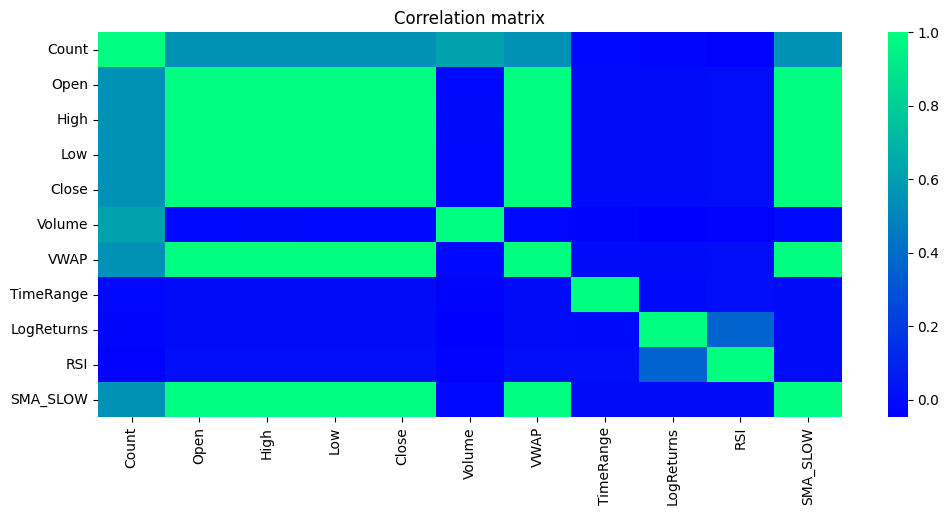

In [46]:
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=False, cmap="winter")
_ = plt.title("Correlation matrix")

In [47]:
# Select upper triangle of correlation matrix (because it's a symmetric matrix)
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))
#print(upper)

# Find features with correlation greater than a fixed threshold
threshold = 0.9
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print(to_drop)

['High', 'Low', 'Close', 'VWAP', 'SMA_SLOW']


In [50]:
# Drop highly correlated features
to_drop = ["Open", "High", "Low", "VWAP", "Rolled_Avg_Close", "BBANDS_U", "BBANDS_M", "BBANDS_L", "SMA_SLOW", "SMA_MEDIUM", "SMA_FAST"]
try:
    if len(to_drop) != 0:
        X.drop(to_drop, axis=1, inplace=True)
        print("Removing high-correlated columns")
except KeyError as e:
    print("High-correlated features already removed")

High-correlated features already removed


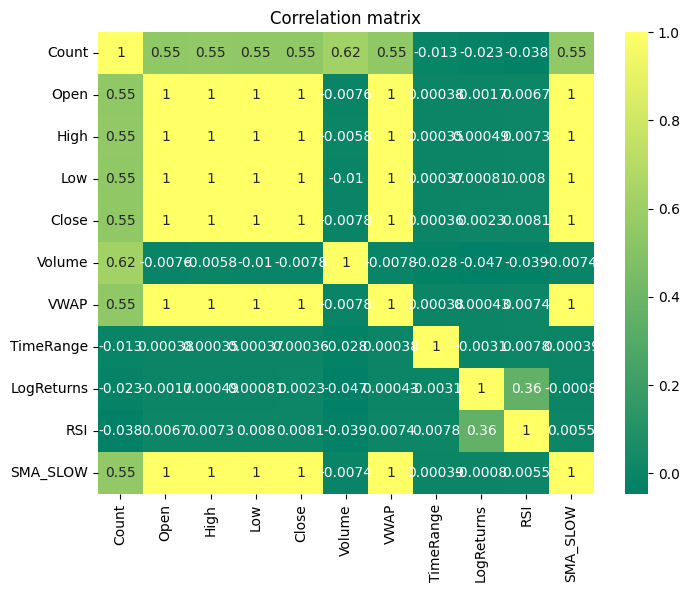

In [49]:
_ = plt.figure(figsize=(8, 6))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="summer")
_ = plt.title("Correlation matrix")

In [422]:
# Outliers detection + removing (Winsorize methods)

In [84]:
# Confusion matrix + see report on + Intro ML Bologna

In [87]:
df.corr().style.background_gradient(cmap='autumn')

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,RSI,SMA_SLOW,Target
Count,1.000000,0.549671,0.551852,0.546709,0.549534,0.617805,0.549551,-0.012566,-0.022755,-0.037586,0.550006,0.003873
Open,0.549671,1.000000,0.999984,0.999975,0.999986,-0.007649,0.999995,0.000381,-0.001673,0.006653,0.999992,-0.007788
High,0.551852,0.999984,1.000000,0.999953,0.999985,-0.005769,0.999988,0.000350,0.000487,0.007311,0.999981,-0.007839
Low,0.546709,0.999975,0.999953,1.000000,0.999978,-0.010272,0.999981,0.000366,0.000806,0.007957,0.999967,-0.007903
Close,0.549534,0.999986,0.999985,0.999978,1.000000,-0.007813,0.999996,0.000364,0.002319,0.008111,0.999984,-0.007941
Volume,0.617805,-0.007649,-0.005769,-0.010272,-0.007813,1.000000,-0.007775,-0.027802,-0.047456,-0.038641,-0.007425,0.009684
VWAP,0.549551,0.999995,0.999988,0.999981,0.999996,-0.007775,1.000000,0.000376,0.000426,0.007442,0.999990,-0.007857
TimeRange,-0.012566,0.000381,0.000350,0.000366,0.000364,-0.027802,0.000376,1.000000,-0.003102,0.007793,0.000394,0.000893
LogReturns,-0.022755,-0.001673,0.000487,0.000806,0.002319,-0.047456,0.000426,-0.003102,1.000000,0.360793,-0.000796,-0.052254
RSI,-0.037586,0.006653,0.007311,0.007957,0.008111,-0.038641,0.007442,0.007793,0.360793,1.000000,0.005541,-0.073889


In [423]:
# GridSearch on model with the 5-10 best features

In [64]:
# Getting initial dataset (subset of time range)
btc_2018 = df["2018-01": "2018-04"]

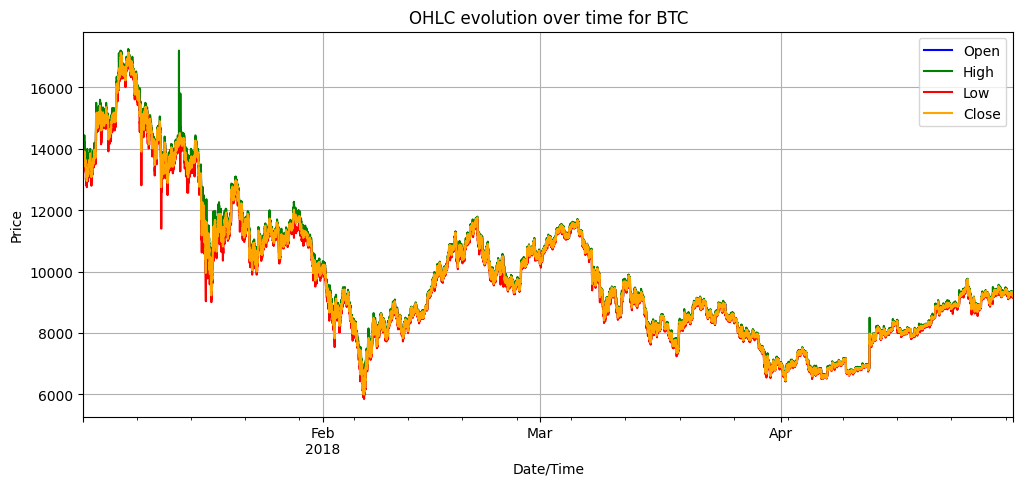

In [71]:
# Plotting OHLC time series
_ = btc_2018[Utils.OHLC].plot()
_ = plt.grid()
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Price")
_ = plt.title("OHLC evolution over time for BTC")

In [76]:
# Getting DataFrame shape
nb_obs, nb_cols = btc_2018.shape
print(f"Number of 10-min bins:\t {nb_obs}\nNumber of columns:\t {nb_cols}")

Number of 10-min bins:	 17260
Number of columns:	 12


In [77]:
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import *
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [78]:
# Test on WF

# Splitting X/Y
X = btc_2018.copy() # X as a deep copy for security reason
Y = X.pop("Target")

# Defining the number of train points and number of records
n_train = 5_000
n_records = 5_200 #len(btc_2018)//2

# Declaring the main model
model = XGBClassifier(learning_rate=0.03, n_estimators=200)

# Model name (on-disk storage)
MODEL_NAME = "model_1"

# Horizon lags
HORIZON_LAGS = {
    "future": 10,
    "past": None
}

# Metrics
METRICS = {
    "train_size": {}, # Shape of the train set
    "test_size": {}, # Shape of the test set
    "exec_time": {}, # Execution (fitting + prediction) time
    "model_size": {} # File size of the on-disk model
}

# Predictions
preds_cols = ["ts"] + [str(i) for i in range(1, 11)] + ["conf_mat"]
preds = pd.DataFrame(columns=preds_cols)

for k, i in enumerate(range(n_train, n_records)):
    print(k, "--", i)
    
    # Train/test split for X
    X_train = X.iloc[0: i]
    X_test = X.iloc[i: i + HORIZON_LAGS["future"]]
    
    # Getting the current datetime
    dt_now = list(X_train.index)[-1]
    
    # Defining the scaler pre-processor
    scaler = MinMaxScaler()
    
    # Scaling X_train
    X_train_scaled = scaler.fit_transform(X_train)
    # - None: XGBoost model fitting with X_train_scaled & Y_train
    # - X_test_scaled: Scaling of X_test using this scaler with input as X_test
    # - Y_pred: XGBoost model prediction with input X_test_scaled
    
    # Saving lengths
    METRICS["train_size"][dt_now] = len(X_train)
    METRICS["test_size"][dt_now] = len(X_test)

    # Train/test split for Y
    Y_train = Y.iloc[0: i]
    Y_test = Y.iloc[i: i + HORIZON_LAGS["future"]]
    
    # Timing the fitting & prediction operations
    start_time = time.time()
    
    # If first iteration, only fit
    if k == 0:
        model.fit(X=X_train, y=Y_train) # or X_train_scaled
    else:
        # If next iterations, fitting using previous knowledge (saved on-disk)
        model.fit(X=X_train, y=Y_train, xgb_model=MODEL_NAME) # or X_train_scaled
    
    # TODO: Use the i counter to track iterations on MODEL_NAME to re-use on 
    
    # Saving the model for incremental learning (growing filtration)
    model.get_booster().save_model(MODEL_NAME)
    
    # Scaling the X_test dataset with the scaler trained on X_train
    X_test_scaled = scaler.transform(X_test)
    
    # Predicting the HORIZON_LAGS["future"] market movements from dt_now
    Y_pred = model.predict(X=X_test) # or X_test_scaled
    #print(Y_pred)
    
    if k == 0:
        METRICS["model_size"][dt_now] = 0.0
    else:
        METRICS["model_size"][dt_now] = os.path.getsize(MODEL_NAME)/1e6
    
    # Storing the duration time for fitting step
    dur_time = time.time() - start_time
    METRICS["exec_time"][dt_now] = dur_time
    print(f"Exec. time: {dur_time:.3f}s")
    
    # Computing the confusion matrix
    conf_mat = confusion_matrix(y_true=list(Y_test.values), y_pred=list(Y_pred))
    #print(conf_mat)
    
    # Appending the predictions
    preds = preds.append(pd.DataFrame([[dt_now] + list(Y_pred) + [conf_mat]], columns=preds_cols), ignore_index=True)
    
    #print(train.shape, test.shape)

0 -- 5000
Exec. time: 0.692s
1 -- 5001
Exec. time: 0.705s
2 -- 5002
Exec. time: 0.659s
3 -- 5003
Exec. time: 0.677s
4 -- 5004
Exec. time: 0.672s
5 -- 5005
Exec. time: 0.764s
6 -- 5006
Exec. time: 0.723s
7 -- 5007
Exec. time: 0.714s
8 -- 5008
Exec. time: 0.760s
9 -- 5009
Exec. time: 0.745s
10 -- 5010
Exec. time: 0.798s
11 -- 5011
Exec. time: 0.807s
12 -- 5012
Exec. time: 0.808s
13 -- 5013
Exec. time: 0.790s
14 -- 5014
Exec. time: 0.994s
15 -- 5015
Exec. time: 0.974s
16 -- 5016
Exec. time: 0.827s
17 -- 5017
Exec. time: 0.845s
18 -- 5018
Exec. time: 0.830s
19 -- 5019
Exec. time: 0.860s
20 -- 5020
Exec. time: 0.870s
21 -- 5021
Exec. time: 0.894s
22 -- 5022
Exec. time: 0.948s
23 -- 5023
Exec. time: 0.958s
24 -- 5024
Exec. time: 0.965s
25 -- 5025
Exec. time: 0.977s
26 -- 5026
Exec. time: 0.953s
27 -- 5027
Exec. time: 0.962s
28 -- 5028
Exec. time: 1.037s
29 -- 5029
Exec. time: 0.981s
30 -- 5030
Exec. time: 1.002s
31 -- 5031
Exec. time: 1.037s
32 -- 5032
Exec. time: 1.085s
33 -- 5033
Exec. tim

**References**:
1. https://greyhoundanalytics.com/blog/backtestingpy-a-complete-quickstart-guide/
2. https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#backtesting.backtesting.Backtest.plot
3. https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

In [79]:
# Broadcasting into a Pandas DataFrame
METRICS_ = pd.DataFrame(METRICS)

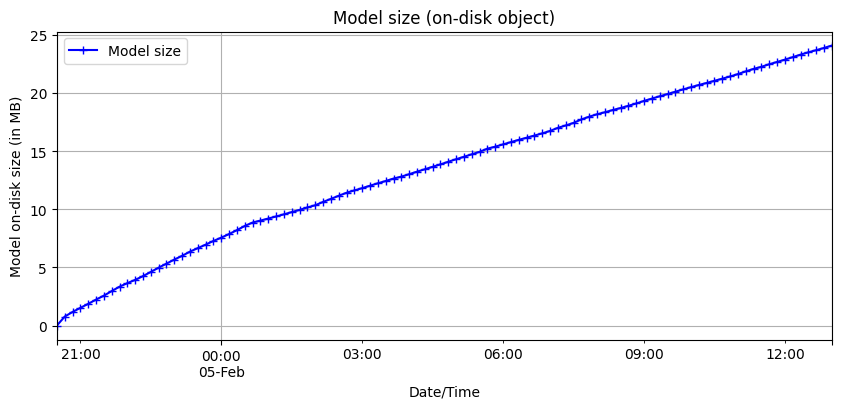

In [80]:
_ = METRICS_["model_size"].plot(marker="+", label="Model size", figsize=(10, 4))
_ = plt.grid()
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Model on-disk size (in MB)")
_ = plt.title("Model size (on-disk object)")
_ = plt.legend()

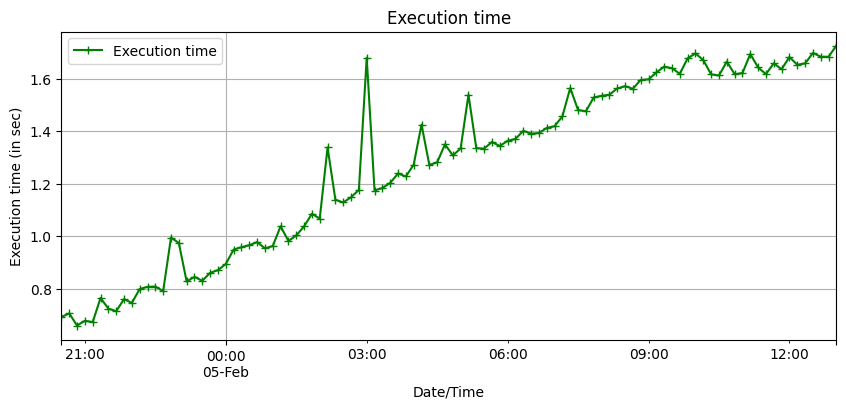

In [81]:
_ = METRICS_["exec_time"].plot(marker="+", label="Execution time", figsize=(10, 4), color="green")
_ = plt.grid()
_ = plt.xlabel("Date/Time")
_ = plt.ylabel("Execution time (in sec)")
_ = plt.title("Execution time")
_ = plt.legend()

In [82]:
preds["conf_mat"].mean()

array([[2.68, 3.31],
       [2.31, 1.7 ]])

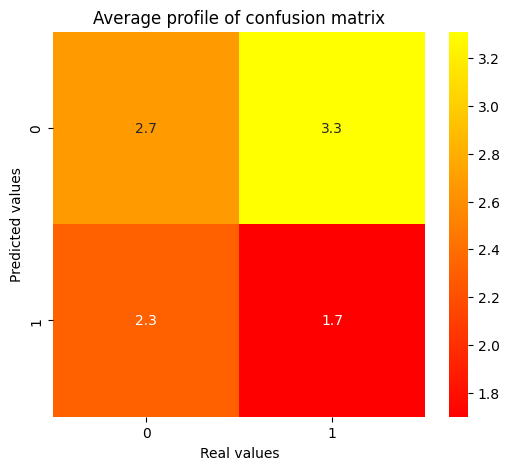

In [83]:
_ = plt.figure(figsize=(6, 5))
_ = sns.heatmap(preds["conf_mat"].mean(), annot=True, cmap="autumn")
_ = plt.title("Average profile of confusion matrix")
_ = plt.xlabel("Real values")
_ = plt.ylabel("Predicted values")

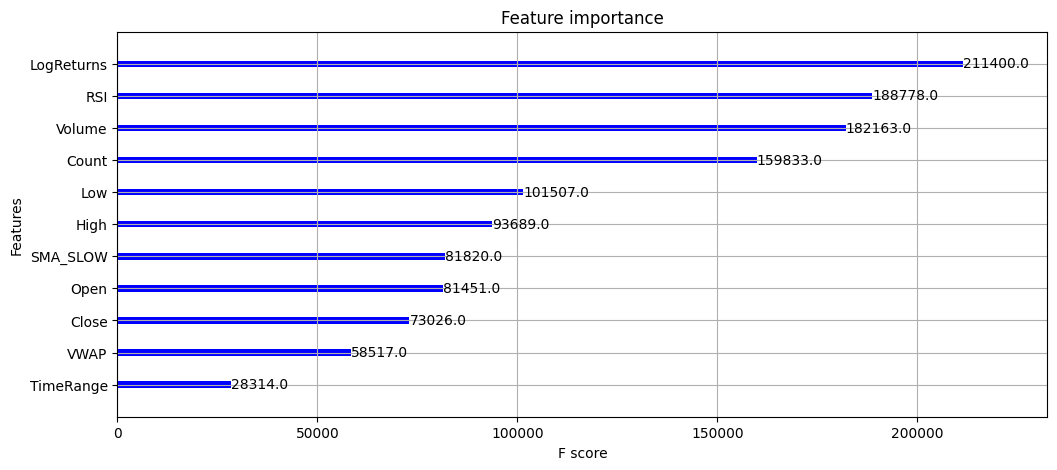

In [272]:
# Plot features 
_ = plot_importance(booster=model.get_booster())

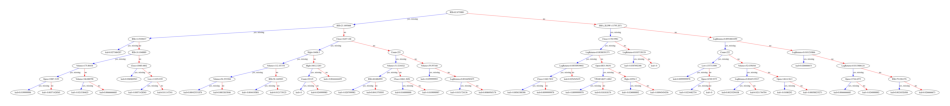

In [273]:
_ = plot_tree(booster=model.get_booster())

In [408]:
# Defining the trading strategy
import datetime
import xgboost
import pandas_ta as tap
import pandas as pd
from backtesting import Backtest
from backtesting import Strategy
from backtesting.lib import crossover
from backtesting.test import EURUSD
from backtesting.lib import resample_apply

# Dataset
btc_2018 = df["2018": "2018"]

class RsiOscillator(Strategy):
    upper_bound = 70
    lower_bound = 30
    rsi_window = 3

    # Do as much initial computation as possible
    def init(self):
        self.daily_rsi = self.I(tap.rsi, pd.Series(self.data.Close), self.rsi_window)
    
    # Step through bars one by one
    # Note that multiple buys are a thing here
    def next(self):
        #print(len(self.data.df))
        price = self.data.df.iloc[-1]
        #print(type(price))
        
        
        # Use the history (thanks to the I (indicator function)) + 
        # Use the prediction for the l (future lag) next 10 iterations from now on 
        # To do so, we are taking the current_dt and adding the delta (l: future lag to get a dataframe/series
        # with our different predicted models (binary target and/or another ))
        # For instance, check whether we have an increasing/decreasing trend for the next values
        
        current_dt = price.name
        #print(current_dt, price["Close"])
        #print("---")
        self.hello_world()
        if crossover(self.daily_rsi, self.upper_bound):
            self.position.close()

        elif crossover(self.lower_bound, self.daily_rsi):
            self.buy()

In [409]:
class BT(Backtest):
    def __init__(self, *args, **kwargs):
        print("Initializing the backtest instance ...")
        super().__init__(*args, **kwargs)
        self._strategy.hello_world = lambda x: x == 1
    
    def run(self, *args, **kwargs):
        print("Running ...")
        return super().run(*args, **kwargs)

In [410]:
bt = BT(btc_2018[0: 40000], RsiOscillator, cash=10_000, commission=.002)

Initializing the backtest instance ...


In [411]:
# Defining the backtesting object for the given strategy
#bt = Backtest(btc_2018[0: 10000], RsiOscillator, cash=10_000, commission=.002)

In [412]:
# Running the backtesting operation
stats = bt.run()

Running ...


In [413]:
# Defining the current timestamp (string representation)
dt_now = datetime.datetime.now().strftime("%m-%d-%Y_%H-%M-%S")

# Plotting the results curves (in the Jupyter notebook)
_ = bt.plot()

# Saving on-disk the results curves as HTML page
_ = bt.plot(filename=f"../out/backtests/plots/plots_{dt_now}")

# Collecting statistical output from backtest
bt_results = stats

In [414]:
# Getting the statistical output from backtest (broadcasting into a Python dict from a BT stat type)
bt_results_ = {k:v for k, v in bt_results.items() if k not in ["_trades", "_equity_curve", "_strategy"]}

# Getting the output strategy instance
bt_strategy = bt_results["_strategy"]

# Getting the equity curve
bt_equity_curve = bt_results["_equity_curve"]

# Getting the trades table
bt_trades = bt_results["_trades"]

In [417]:
# Saving on-disk 
bt_trades.to_csv(f"../out/backtests/trades/trades_{dt_now}.csv")
bt_equity_curve.to_csv(f"../out/backtests/equity_curves/ec_{dt_now}.csv")

In [418]:
bt_results_

{'Start': Timestamp('2018-01-01 06:20:00'),
 'End': Timestamp('2018-10-06 00:50:00'),
 'Duration': Timedelta('277 days 18:30:00'),
 'Exposure Time [%]': 10.290000000000001,
 'Equity Final [$]': 5901.450786002049,
 'Equity Peak [$]': 10965.349325351663,
 'Return [%]': -40.985492139979506,
 'Buy & Hold Return [%]': -51.883460852176796,
 'Return (Ann.) [%]': -49.839913894013,
 'Volatility (Ann.) [%]': 17.17581866075471,
 'Sharpe Ratio': 0.0,
 'Sortino Ratio': 0.0,
 'Calmar Ratio': 0.0,
 'Max. Drawdown [%]': -47.014418811969314,
 'Avg. Drawdown [%]': -12.325091968732046,
 'Max. Drawdown Duration': Timedelta('252 days 10:30:00'),
 'Avg. Drawdown Duration': Timedelta('52 days 07:00:00'),
 '# Trades': 374,
 'Win Rate [%]': 56.951871657754005,
 'Best Trade [%]': 4.786282716537116,
 'Worst Trade [%]': -7.421759604369271,
 'Avg. Trade [%]': -0.1486868546490716,
 'Max. Trade Duration': Timedelta('0 days 08:40:00'),
 'Avg. Trade Duration': Timedelta('0 days 01:41:00'),
 'Profit Factor': 0.76489620

In [416]:
btc_2018[:][2:26]

,Count,Open,High,Low,Close,Volume,VWAP,TimeRange,LogReturns,Target,...,Corr,Open-Close,Open-Open,RSI,BBANDS_U,BBANDS_M,BBANDS_L,SMA_SLOW,SMA_MEDIUM,SMA_FAST
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 06:40:00,260.0,13718.2380,14442.9,13644.990000,13801.032000,49.739558,13780.980585,0,0.006006,1,...,0.665895,-0.160000,-1.2720,74.396604,13759.686806,13586.581100,13413.475394,13670.950800,13626.582200,13616.111600
2018-01-01 06:50:00,278.5,13801.0340,14141.0,13713.260000,13868.724000,54.396066,13859.155262,0,0.004893,1,...,0.881893,0.002000,82.7960,78.243280,13813.613911,13601.832700,13390.051489,13736.937600,13649.835600,13638.266533
2018-01-01 07:00:00,296.0,13865.9440,14224.0,13738.980000,13917.490000,26.822479,13888.212163,0,0.003510,0,...,0.941397,-2.780000,64.9100,80.578886,13870.985494,13620.233200,13369.480906,13804.252800,13681.119400,13661.168267
2018-01-01 07:10:00,273.5,13928.5560,14200.0,13600.000000,13784.644000,37.799960,13852.301551,0,-0.009591,1,...,0.819162,11.066000,62.6120,60.817291,13888.422029,13634.616100,13380.810171,13818.057600,13704.379400,13672.589467
2018-01-01 07:20:00,157.5,13789.4440,14052.6,13605.090000,13811.102000,30.676385,13794.868481,0,0.001918,0,...,0.739362,4.800000,-139.1120,62.834305,13904.044279,13652.050000,13400.055721,13836.598400,13729.039200,13683.125467
2018-01-01 07:30:00,170.5,13798.3620,14123.0,13650.000000,13786.030000,21.834104,13811.795528,0,-0.001817,0,...,0.628951,-12.740000,8.9180,59.603747,13904.399418,13670.483200,13436.566982,13833.598000,13752.274400,13695.587467
2018-01-01 07:40:00,218.0,13789.5480,14030.1,13555.980000,13688.578000,47.322837,13725.840631,0,-0.007094,0,...,0.299656,3.518000,-8.8140,48.773794,13903.824329,13678.092100,13452.359871,13797.568800,13767.253200,13699.080000
2018-01-01 07:50:00,168.5,13691.3080,14060.0,13555.020000,13682.164000,22.559285,13694.412312,0,-0.000469,0,...,-0.196369,2.730000,-98.2400,48.134203,13904.121117,13683.502100,13462.883083,13750.503600,13777.378200,13704.247467
2018-01-01 08:00:00,164.0,13680.1860,14120.4,13520.000000,13620.555000,20.852116,13648.916404,0,-0.004513,1,...,-0.496338,-1.978000,-11.1220,42.224649,13904.044745,13683.863550,13463.682355,13717.685800,13767.871700,13708.814867


In [419]:
X[:].iloc[-1].name

Timestamp('2022-01-24 00:00:00', freq='10T')